In [1]:
import random
import numpy as np
import pandas as pd
import re

import seaborn as sns
import matplotlib.pyplot as plt

from local_libs.Get_Categories import CategorySelector
from local_libs.color_filter import bcolors as cf
from local_libs.clear_data import clear_data_train
from local_libs.clear_data import clear_data_test

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import nltk

#Downloads necessários para executar o código
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

import warnings
warnings.simplefilter('ignore', UserWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\augus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\augus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\augus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\augus\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
def export_dataset():
    #Lista de links (arquivos estão dentro do Google Sheets)
    test_links = {
        'link_01': 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQvClyfCtk8JD82zXYSipnN7iCJ0XG0V-z6tcII_14W7tQYPpLLOK45kKWLQf8TBfyRNhH9mlEXiowR/pub?output=csv',
        'link_02': 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQq0fLn7Dkg0-Lg2i9FUD0iL-xLVHn1Gtorx8wLlA7flMftChIJf_PXgziaHshCnxlX52bZJZ2EKFsu/pub?output=csv'
    }
    train_links ={
        'link_01':'https://docs.google.com/spreadsheets/d/e/2PACX-1vS2E4FyELPrgf1rPIeyh4lzQTOtftYYK6vyr7m5TN7cYDZTo4tLy1jZQ06mnnwo0NrJ5ZR5IOm2-ndN/pub?output=csv',
        'link_02':'https://docs.google.com/spreadsheets/d/e/2PACX-1vT-NHTDb71tp400NvyVObenotd8uUATgPgl4nlGwvqpwTTMoCmc8bH7YmyvmzBg_TcIAxoNkC0upfoe/pub?output=csv',       
        'link_03':'https://docs.google.com/spreadsheets/d/e/2PACX-1vT_vX9ELHWxTt5kPrcZ8LchIXnBrd2QvbsuA5f_cHLWhaSvoa9DERR5W7oKE9489UzfFruwyek2XJvW/pub?output=csv',
        'link_04':'https://docs.google.com/spreadsheets/d/e/2PACX-1vSi7JewvqVkONWiqbFWqyQjTOmtxrsEtZ4ArifmlCMELo9BAPw00BpnZ1BI9wx_ruE4nPbY3egzjEfx/pub?output=csv',
        'link_05':'https://docs.google.com/spreadsheets/d/e/2PACX-1vTooCcyaoXnkazJ6HI95oc-Ll45cMY4qnjh6iIa9HVJfhTej2z9EBDVVHgplEhqLfegmeucud1mXMhS/pub?output=csv'
    }
   
    #Download e leitura do arquivo de treinamento
    temp_df_test = pd.DataFrame()
    for i in test_links:
        file_temp = pd.read_csv(test_links[i])
        temp_df_test = pd.concat([temp_df_test,file_temp]) 
    temp_df_test.reset_index(drop=True, inplace=True)
    temp_df_test.drop('Unnamed: 0',axis=1, inplace= True)

    #Download e leitura do arquivo de teste
    temp_df_train = pd.DataFrame()
    for i in train_links:
        file_temp = pd.read_csv(train_links[i])
        temp_df_train = pd.concat([temp_df_train,file_temp]) 
    temp_df_train.reset_index(drop=True, inplace=True)
    temp_df_train.drop('Unnamed: 0',axis=1, inplace= True)   
   
    return temp_df_test, temp_df_train

test, train = export_dataset()

# Dicionário de dados

| Nome da coluna | Tipo | Descrição | Observação |
| :---- | :---- | :--- | :--- |
| test_id | Numérica discreta | Representa o índice do produto | - |
| name | Categórico nominal | Titulo da lista* | - |
| item_condition_id | Catégorico ordinal | Numero que identifica a condição do item | Está em escala de 1 a 5, sendo 1 a melhor e 5 a pior |
| category_name | Categórico nominal | Categorias vinculadas ao produto | - |
| brand_name | Categórico nominal | Nome da marca do item | - |
| price | Numérica discreta | Preço do produto anunciado | Coluna alvo do arquivo teste |
| shipping | Categórico nominal | Identifica quem pagou a taxa de envio | <p>1 - Vendedor</p><p> 0 - Comprador</p> |
| item_description | Categórico nominal | Descrição completa do item* | - |
| date | Categórico ordinal | Data da venda | - |
| stock | Numérico ordinal | Quantidade em estoque | - |

# Treinamento

## Primeiras informações sobre o dataset

In [3]:
#Função responsável por montagem de gráfico de barras
#Caso countplot seja igual a "False", é necessário forncer um y
def criar_barplot(dados,titulo, x , y = None , countplot = False):
  if countplot == False:
    fig = sns.barplot(x=x,y=y,data=dados)
    fig.figure.set_size_inches(24,6)
    fig.set_title(titulo,fontsize=18)
    fig.set_xlabel('Categoria',fontsize=14)
    fig.set_ylabel('Quantidade',fontsize=14)
  else:
    fig = sns.countplot(x=x,data=dados)
    fig.figure.set_size_inches(24,6)
    fig.set_title(titulo,fontsize=18)
    fig.set_xlabel('Categoria',fontsize=14)
    fig.set_ylabel('Quantidade',fontsize=14)
  return fig

<AxesSubplot:title={'center':'Quantidade total dividos por qualidade do item'}, xlabel='Categoria', ylabel='Quantidade'>

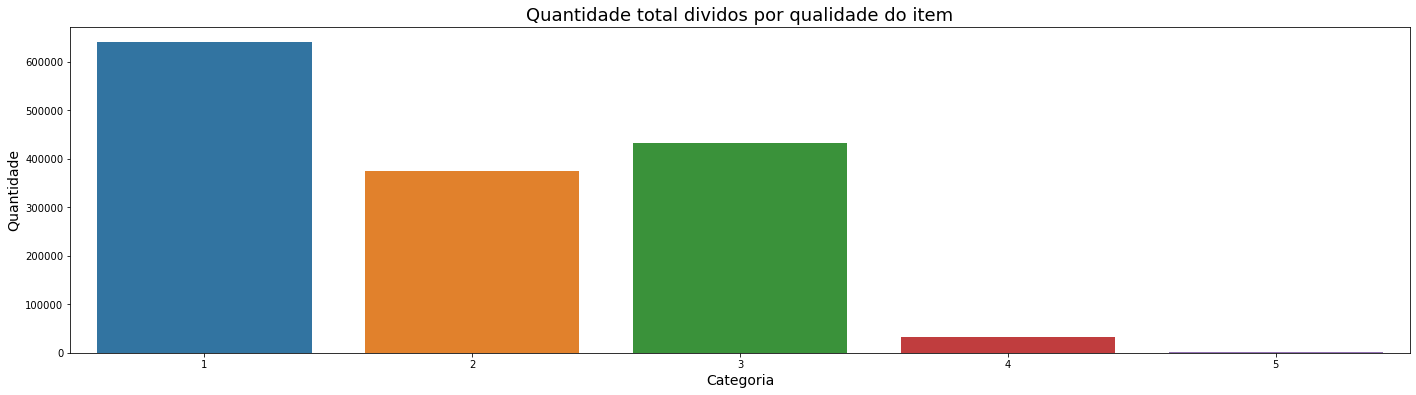

In [4]:
criar_barplot(train, 'Quantidade total dividos por qualidade do item', x = 'item_condition_id', countplot=True)

<AxesSubplot:title={'center':'Quantidade total dividos por qualidade do item'}, xlabel='Categoria', ylabel='Quantidade'>

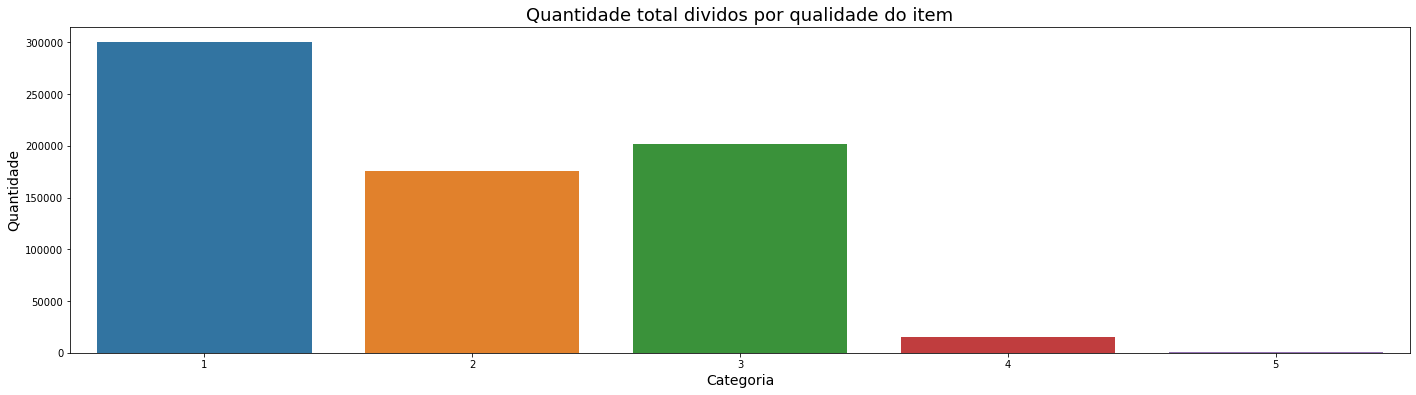

In [5]:
criar_barplot(test, 'Quantidade total dividos por qualidade do item', x = 'item_condition_id', countplot=True)

<AxesSubplot:title={'center':'Quantidade em porcentagem dividos pela qualidade do item'}, xlabel='Categoria', ylabel='Quantidade'>

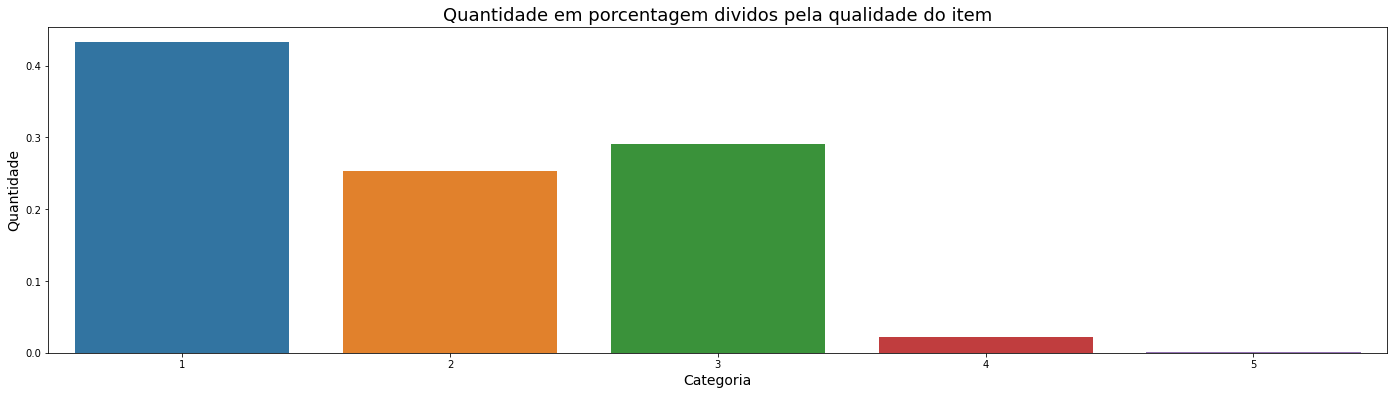

In [6]:
test_percentage = pd.DataFrame(test.value_counts('item_condition_id', normalize = True).reset_index(drop=False))
test_percentage
criar_barplot(test_percentage, 'Quantidade em porcentagem dividos pela qualidade do item', x = 'item_condition_id', y = 0)

<AxesSubplot:title={'center':'Quantidade em porcentagem dividos pela qualidade do item'}, xlabel='Categoria', ylabel='Quantidade'>

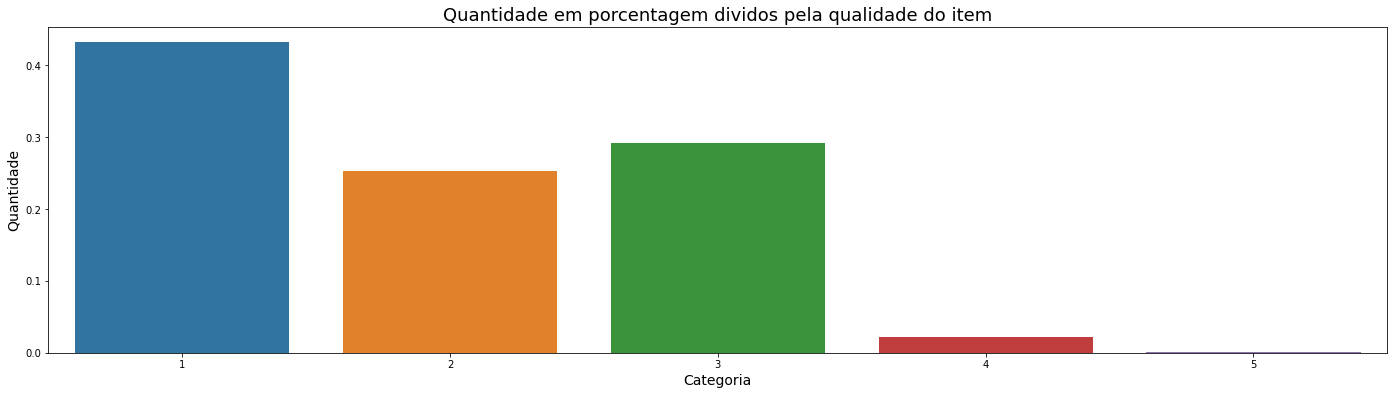

In [7]:
train_percentage = pd.DataFrame(train.value_counts('item_condition_id', normalize = True).reset_index(drop=False))
train_percentage
criar_barplot(train_percentage, 'Quantidade em porcentagem dividos pela qualidade do item', x = 'item_condition_id', y = 0)

In [8]:
print('Information about train')
print('\n')
print(f'\tNumber of samples: {cf.GREEN}{train.shape[0]}{cf.ENDC} | Number of columns: {cf.GREEN}{train.shape[1]}{cf.ENDC} ')
print(f'\tTrain column names: {cf.BOLD}{list(train.columns)}{cf.ENDC}')
print('\n')
print('__________________________________________________________________')
print('\n')
print('Information about test')
print('\n')
print(f'\tNumber of samples: {cf.GREEN}{test.shape[0]}{cf.ENDC} | Number of columns: {cf.GREEN}{test.shape[1]}{cf.ENDC} ')
print(f'\tTrain column names: {cf.BOLD}{list(test.columns)}{cf.ENDC}')

Information about train


	Number of samples: 1482535 | Number of columns: 10 
	Train column names: ['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name', 'price', 'shipping', 'item_description', 'date', 'stock']


__________________________________________________________________


Information about test


	Number of samples: 693359 | Number of columns: 9 
	Train column names: ['test_id', 'name', 'item_condition_id', 'category_name', 'brand_name', 'shipping', 'item_description', 'date', 'stock']


In [9]:
print('Information about train')
print('\n')
print(train.info())
print('\n')
print('__________________________________________________________________')
print('\n')
print('Information about test')
print('\n')
print(test.info())

Information about train


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 10 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476256 non-null  object 
 4   brand_name         850368 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
 8   date               1482535 non-null  object 
 9   stock              1482535 non-null  int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 113.1+ MB
None


__________________________________________________________________


Information about test


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693359 entries, 0 to 693358
Data columns (tota

In [10]:
print(f'Número de amostras nulas na coluna "category_name": {cf.RED}{train[train.category_name.isnull()].shape[0]}{cf.ENDC}')
print('\n')
print(f'Número de amostras nulas na coluna "brand_name": {cf.RED}{train[train.brand_name.isnull()].shape[0]}{cf.ENDC}')
print('\n')
print(f'Número de amostras nulas na coluna "item_description": {cf.RED}{train[train.item_description.isnull()].shape[0]}{cf.ENDC}')

Número de amostras nulas na coluna "category_name": 6279


Número de amostras nulas na coluna "brand_name": 632167


Número de amostras nulas na coluna "item_description": 4


## Limpeza de dados

In [11]:
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

In [12]:
train = clear_data_train(train)

In [13]:
#Função para tratar cada palavra e remover stopwords
def processamento(tokens):
    
    token_processado = []
    for token in tokens:
        token = token.lower()
        token = lemmatizer.lemmatize(token)
        
        if token not in stop_words:
            token = stemmer.stem(token)
            token_processado.append(token)
        
    return token_processado

#Expressao regular para remover pontuacoes do texto da coluna 
description = train['item_description']
documentos_descript = []
for descript in description:
    
    #Expressao regular para remover pontuacoes do texto item_description
    descript = re.sub(r'[^\w\s]','', descript)
    tokens = processamento(word_tokenize(descript))
    
    documentos_descript.append(' '.join(tokens))

In [14]:
#Expressao regular para remover pontuacoes do texto da coluna name
name_2 = train['name']
documentos_name = []
for name_3 in name_2:
    
    
    sinopse = re.sub(r'[^\w\s]','', name_3)
    tokens = processamento(word_tokenize(name_3))
    
    documentos_name.append(' '.join(tokens))

In [15]:
#Criando a coluna documento_descript
train['description_clear'] = documentos_descript
train['name_clear'] = documentos_name

In [16]:
#Remoção dos itens duplicados
# index_duplicated = train[train[['category_name', 'name_clear','description_clear','date','price']].duplicated()].index
index_duplicated = train[train[['category_name','date','price']].duplicated()].index
train = train.drop(index_duplicated, axis=0).reset_index(drop=True)

In [17]:
train.head()

,name,item_condition_id,category_name,brand_name,price,shipping,item_description,date,stock,date2,day,month,year,description_clear,name_clear
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,Other,10.0,1,No description yet,17-5-2018,27,2018-05-17,17,5,2018,descript yet,mlb cincinnati red shirt size xl
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,17-3-2018,15,2018-03-17,17,3,2018,keyboard great condit work like came box port ...,razer blackwidow chroma keyboard
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,24-10-2018,14,2018-10-24,24,10,2018,ador top hint lace key hole back pale pink 1x ...,ava-viv blous
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,Other,35.0,1,New with tags. Leather horses. Retail for [rm]...,19-2-2018,1,2018-02-19,19,2,2018,new tag leather hors retail rm stand foot high...,leather hors statu
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,Other,44.0,0,Complete with certificate of authenticity,16-4-2018,13,2018-04-16,16,4,2018,complet certif authent,24k gold plate rose


## Seletor de categorias

<p style = 'color:red'>Para maiores informações: /local_libs/Get_Categories.py</p>
<p style = 'color:red'>For more informations: /local_libs/Get_Categories.py</p>


In [18]:
# Chamando a classe de seleção de categorias
# Fornecendo as informações principais, sendo que elas são:
# main_frame, a base principal de dados
# column, coluna alvo que servirá de base para seleção de categorias
# main_category_name, retorna uma lista com apenas os nomes das categorias principais
# return_first_category, retorna uma dataframe com a primeira categoria e suas respectivas contagens
# save_files, retorna os arquivos em fornado .csv (verificar armazenamento interno)
# O output da função "get_categories", caso return_first_category são duas variáveis
# second_category_dict é um dicionário em que:

#       A chave do dicionário é uma categoria principal
#       Os dados dentro da chave são todas as linhas da base de dados que tem como categoria principal a chave do dicionário
#       Esses dados precisam ser reindexados

general_selector_train = CategorySelector(train , train['category_name'], return_first_category=True, save_files=True, data_type='train')
first_category_train , second_category_dict_train = general_selector_train.get_categories()

### Primeira categoria

In [19]:
first_category_train

,category_name,Count
0,Women,353006
1,Kids,113698
2,Beauty,96895
3,Electronics,66514
4,Men,62577
5,Home,46497
6,Vintage & Collectibles,34030
7,Other,33392
8,Handmade,21737
9,Sports & Outdoors,18817


<AxesSubplot:title={'center':'Quantitativo de categorias primárias dentro da base de treinamento'}, xlabel='Categoria', ylabel='Quantidade'>

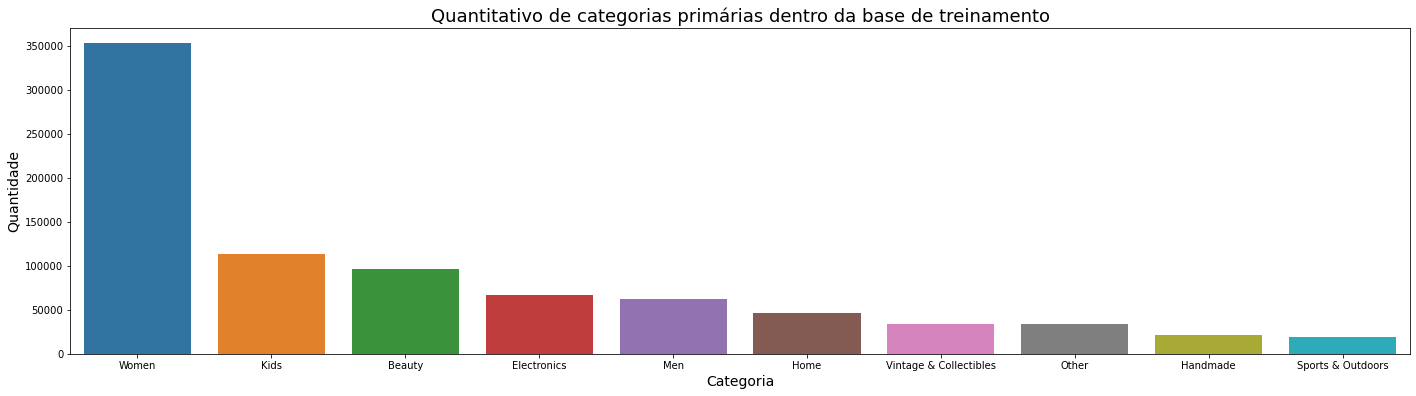

In [20]:
criar_barplot(first_category_train, 'Quantitativo de categorias primárias dentro da base de treinamento', x = 'category_name', y = 'Count')

### Categoria Homem | "Men"

In [21]:
# Já que será chamado uma função secundária da classe, é preciso apenas chamar a classe, não inicia-la
selector = CategorySelector

In [22]:
# É realizado uma limpeza dentro das categorias que apenas contém a categoria principal de homem
# Todos os códigos posteriores respeitam essa linha de raciocínio 
# É acessado o dicionário através do nome de uma categoria principal como chave, acessado a coluna de categorias e reinciado o index, como citado anteriormente
# É passado a função name_and_count_category_level, para mais informações de funcionamento visualizar /local_libs/Get_Categories.py, sendo que o output é:
#       Um dataframe com a contagem e os nomes de cada categoria
#       Um dataframe com a porcentagem e os nomes de cada categoria
#       Seria possível ter os nomes das categorias, mas já que as outras funções já fazem isso não se fez necessário, então foi ignorado esse output

column_men_train = second_category_dict_train['Men']['category_name'].reset_index(drop=True)
men_subcategories_count_train, __ , men_subcategories_percentage_train = selector.name_and_count_category_level(column_men_train, 1, percentage=True)
print(f'Valores totais do treinamento dentro da subcategoria {cf.BLUE}Men{cf.ENDC}')
men_subcategories_count_train

Valores totais do treinamento dentro da subcategoria Men


,category_name,Count
0,Shoes,15196
1,Men's Accessories,13046
2,Tops,10684
3,Athletic Apparel,7910
4,Sweats & Hoodies,5958
5,Jeans,2964
6,Coats & Jackets,2615
7,Shorts,1145
8,Sweaters,1135
9,Pants,730


In [23]:
print(f'Valores percentuais do treinamento da subcategoria {cf.BLUE}Men{cf.ENDC}')
men_subcategories_percentage_train

Valores percentuais do treinamento da subcategoria Men


,category_name,Percentage
0,Shoes,0.242837
1,Men's Accessories,0.208479
2,Tops,0.170734
3,Athletic Apparel,0.126404
4,Sweats & Hoodies,0.095211
5,Jeans,0.047366
6,Coats & Jackets,0.041789
7,Shorts,0.018297
8,Sweaters,0.018138
9,Pants,0.011666


<AxesSubplot:title={'center':'Quantitativo do treinamento das subcategorias da categoria Homem'}, xlabel='Categoria', ylabel='Quantidade'>

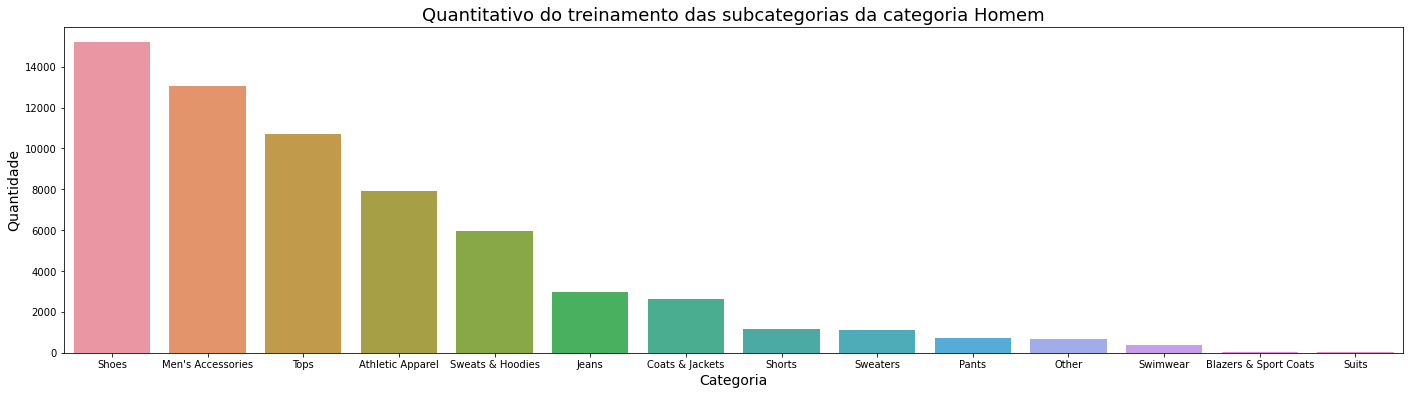

In [24]:
criar_barplot(men_subcategories_count_train, 'Quantitativo do treinamento das subcategorias da categoria Homem', x = 'category_name', y='Count')

### Categoria Mulher | "Women"

In [25]:
column_women_train = second_category_dict_train['Women']['category_name'].reset_index(drop=True)
women_subcategories_count_train, __ , women_subcategories_percentage_train= selector.name_and_count_category_level(column_women_train, 1, percentage=True)
print(f'Valores totais do treinamento dentro da subcategoria {cf.BLUE}Women{cf.ENDC}')
women_subcategories_count_train

Valores totais do treinamento dentro da subcategoria Women


,category_name,Count
0,Athletic Apparel,52807
1,Shoes,46187
2,Tops & Blouses,39696
3,Women's Handbags,31017
4,Jewelry,29635
5,Women's Accessories,27216
6,Dresses,24673
7,Sweaters,22042
8,Jeans,19653
9,Underwear,15462


In [26]:
print(f'Valores percentuais do treinamento da subcategoria {cf.BLUE}Woman{cf.ENDC}')
women_subcategories_percentage_train

Valores percentuais do treinamento da subcategoria Woman


,category_name,Percentage
0,Athletic Apparel,0.149592
1,Shoes,0.130839
2,Tops & Blouses,0.112451
3,Women's Handbags,0.087865
4,Jewelry,0.083950
5,Women's Accessories,0.077098
6,Dresses,0.069894
7,Sweaters,0.062441
8,Jeans,0.055673
9,Underwear,0.043801


<AxesSubplot:title={'center':'Quantitativo do treinamento das subcategorias da categoria Mulher'}, xlabel='Categoria', ylabel='Quantidade'>

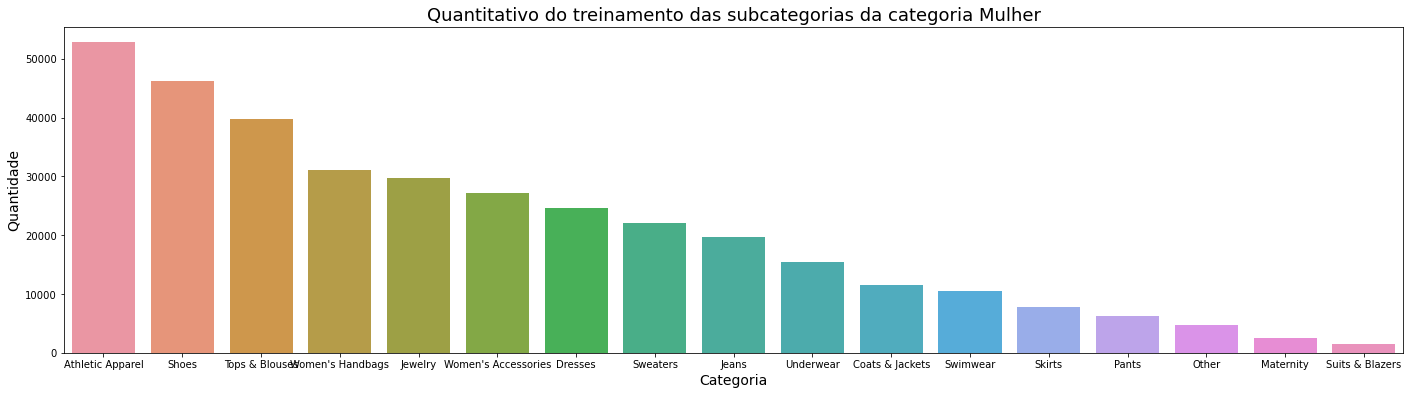

In [27]:
criar_barplot(women_subcategories_count_train, 'Quantitativo do treinamento das subcategorias da categoria Mulher', x = 'category_name', y='Count')

### Categoria Antigos e Colecionáveis | "Vintage & Collectibles"

In [28]:
column_vintage_collectibles_train = second_category_dict_train['Vintage & Collectibles']['category_name'].reset_index(drop=True)
vintage_collectibles_subcategories_count_train, __ , vintage_collectibles_subcategories_percentage_train= selector.name_and_count_category_level(column_vintage_collectibles_train, 1, percentage=True)
print(f'Valores totais do treinamento dentro da subcategoria {cf.BLUE}Vintage & Collectibles{cf.ENDC}')
vintage_collectibles_subcategories_count_train

Valores totais do treinamento dentro da subcategoria Vintage & Collectibles


,category_name,Count
0,Toy,5177
1,Collectibles,4407
2,Antique,4217
3,Trading Cards,4171
4,Bags and Purses,2492
5,Clothing,2062
6,Electronics,2017
7,Jewelry,2001
8,Accessories,1702
9,Serving,1425


In [29]:
print(f'Valores percentuais do treinamento da subcategoria {cf.BLUE}Vintage & Collectibles{cf.ENDC}')
vintage_collectibles_subcategories_percentage_train

Valores percentuais do treinamento da subcategoria Vintage & Collectibles


,category_name,Percentage
0,Toy,0.152130
1,Collectibles,0.129503
2,Antique,0.123920
3,Trading Cards,0.122568
4,Bags and Purses,0.073230
5,Clothing,0.060594
6,Electronics,0.059271
7,Jewelry,0.058801
8,Accessories,0.050015
9,Serving,0.041875


<AxesSubplot:title={'center':'Quantitativo do treinamento das subcategorias da categoria Antigos e Colecionáveis'}, xlabel='Categoria', ylabel='Quantidade'>

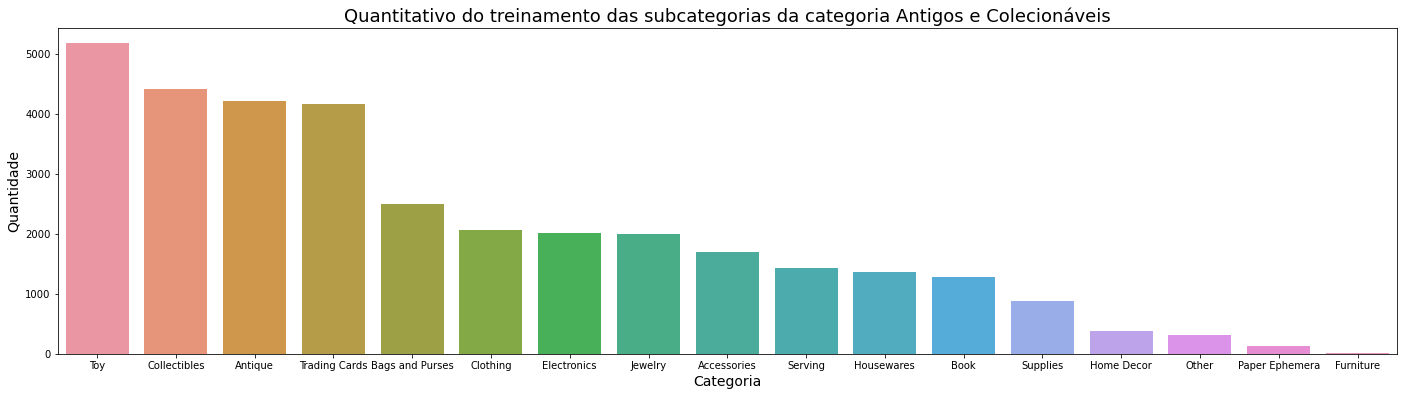

In [30]:
criar_barplot(vintage_collectibles_subcategories_count_train, 'Quantitativo do treinamento das subcategorias da categoria Antigos e Colecionáveis', x = 'category_name', y='Count')

### Categoria Feito a mão | "Handmade"

In [31]:
column_handmade_train = second_category_dict_train['Handmade']['category_name'].reset_index(drop=True)
handmade_subcategories_count_train, __ , handmade_subcategories_percentage_train= selector.name_and_count_category_level(column_handmade_train, 1, percentage=True)
print(f'Valores totais do treinamento dentro da subcategoria {cf.BLUE}Handmade{cf.ENDC}')
handmade_subcategories_count_train

Valores totais do treinamento dentro da subcategoria Handmade


,category_name,Count
0,Accessories,4470
1,Clothing,4001
2,Paper Goods,3421
3,Bags and Purses,2450
4,Jewelry,1569
5,Children,960
6,Music,659
7,Art,522
8,Glass,474
9,Weddings,462


In [32]:
print(f'Valores percentuais do treinamento da subcategoria {cf.BLUE}Handmade{cf.ENDC}')
handmade_subcategories_percentage_train

Valores percentuais do treinamento da subcategoria Handmade


,category_name,Percentage
0,Accessories,0.205640
1,Clothing,0.184064
2,Paper Goods,0.157381
3,Bags and Purses,0.112711
4,Jewelry,0.072181
5,Children,0.044164
6,Music,0.030317
7,Art,0.024014
8,Glass,0.021806
9,Weddings,0.021254


<AxesSubplot:title={'center':'Quantitativo do treinamento das subcategorias da categoria Feito a mão'}, xlabel='Categoria', ylabel='Quantidade'>

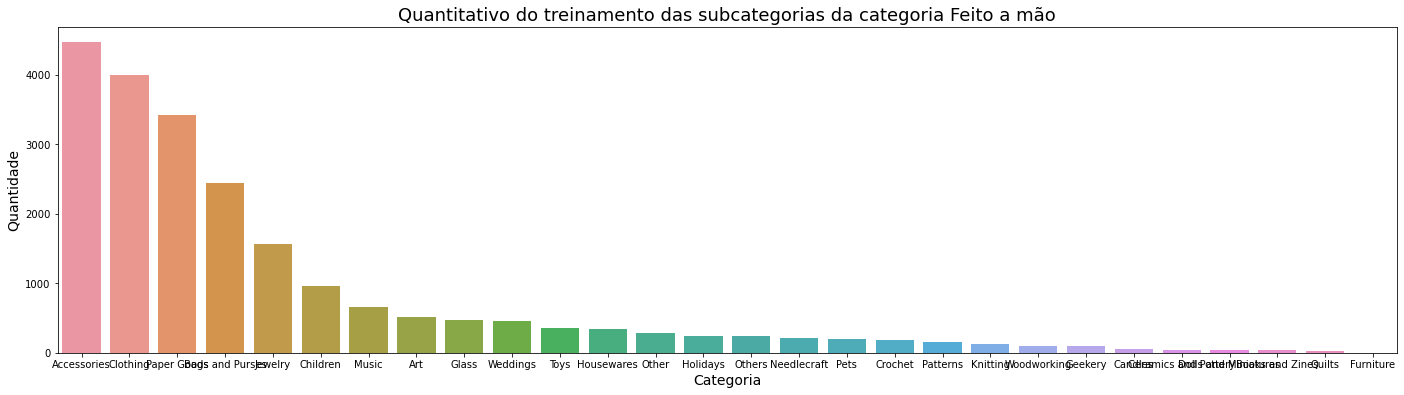

In [33]:
criar_barplot(handmade_subcategories_count_train, 'Quantitativo do treinamento das subcategorias da categoria Feito a mão', x = 'category_name', y='Count')

### Categoria Eletronicos | "Electronics"

In [34]:
column_eletronics_train = second_category_dict_train['Electronics']['category_name'].reset_index(drop=True)
eletronics_subcategories_count_train, __ , eletronics_subcategories_percentage_train= selector.name_and_count_category_level(column_eletronics_train, 1, percentage=True)
print(f'Valores totais do treinamento dentro da subcategoria {cf.BLUE}Electronics{cf.ENDC}')
eletronics_subcategories_count_train

Valores totais do treinamento dentro da subcategoria Electronics


,category_name,Count
0,Cell Phones & Accessories,25075
1,Video Games & Consoles,17599
2,Media,7063
3,"TV, Audio & Surveillance",6862
4,Computers & Tablets,5805
5,Cameras & Photography,3092
6,Other,593
7,"Car Audio, Video & GPS",425


In [35]:
print(f'Valores percentuais do treinamento da subcategoria {cf.BLUE}Electronics{cf.ENDC}')
eletronics_subcategories_percentage_train

Valores percentuais do treinamento da subcategoria Electronics


,category_name,Percentage
0,Cell Phones & Accessories,0.376988
1,Video Games & Consoles,0.264591
2,Media,0.106188
3,"TV, Audio & Surveillance",0.103166
4,Computers & Tablets,0.087275
5,Cameras & Photography,0.046486
6,Other,0.008915
7,"Car Audio, Video & GPS",0.006390


<AxesSubplot:title={'center':'Quantitativo do treinamento das subcategorias da categoria Eletronicos'}, xlabel='Categoria', ylabel='Quantidade'>

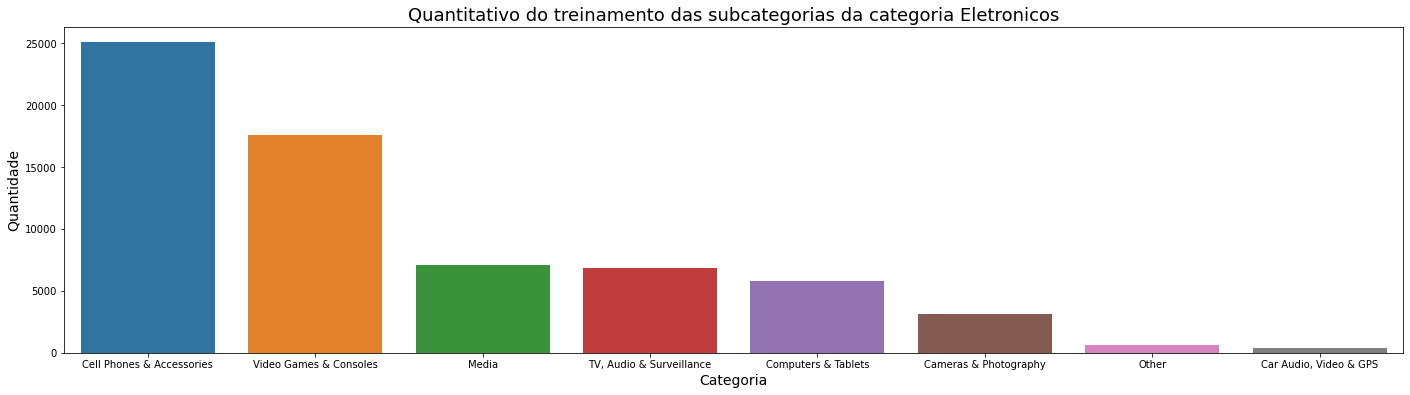

In [36]:
criar_barplot(eletronics_subcategories_count_train, 'Quantitativo do treinamento das subcategorias da categoria Eletronicos', x = 'category_name', y='Count')

### Categoria Casa | "Home"

In [37]:
column_home_train = second_category_dict_train['Home']['category_name'].reset_index(drop=True)
home_subcategories_count_train, __ , home_subcategories_percentage_train= selector.name_and_count_category_level(column_home_train, 1, percentage=True)
print(f'Valores totais do treinamento dentro da subcategoria {cf.BLUE}Vintage & Collectibles{cf.ENDC}')
home_subcategories_count_train

Valores totais do treinamento dentro da subcategoria Vintage & Collectibles


,category_name,Count
0,Home Décor,15699
1,Kitchen & Dining,14982
2,Seasonal Décor,3576
3,Bedding,3301
4,Storage & Organization,2167
5,Home Appliances,2029
6,Cleaning Supplies,1809
7,Artwork,955
8,Bath,921
9,Kids' Home Store,537


In [38]:
print(f'Valores percentuais do treinamento da subcategoria {cf.BLUE}Home{cf.ENDC}')
home_subcategories_percentage_train

Valores percentuais do treinamento da subcategoria Home


,category_name,Percentage
0,Home Décor,0.337635
1,Kitchen & Dining,0.322214
2,Seasonal Décor,0.076908
3,Bedding,0.070994
4,Storage & Organization,0.046605
5,Home Appliances,0.043637
6,Cleaning Supplies,0.038906
7,Artwork,0.020539
8,Bath,0.019808
9,Kids' Home Store,0.011549


<AxesSubplot:title={'center':'Quantitativo do treinamento das subcategorias da categoria Casa'}, xlabel='Categoria', ylabel='Quantidade'>

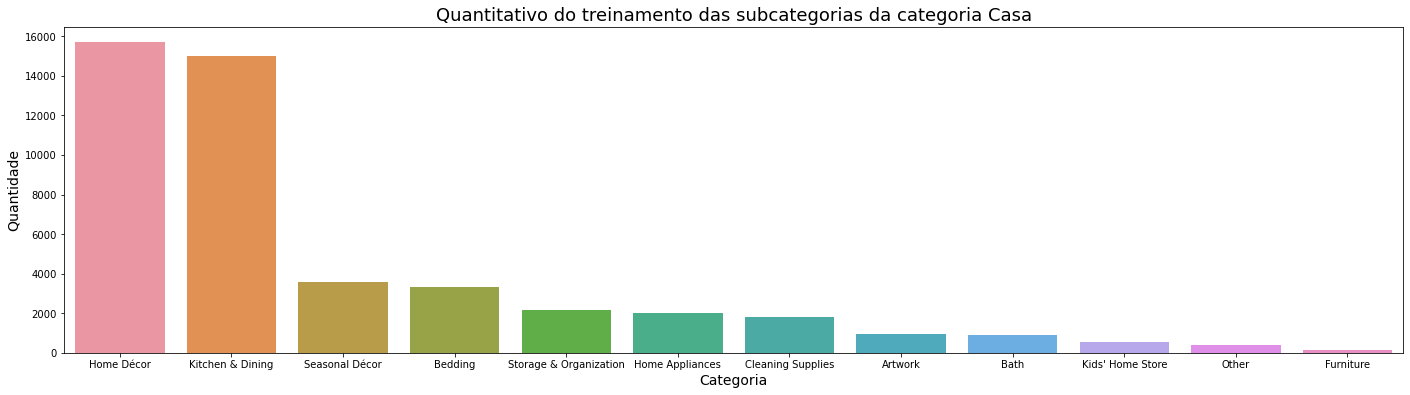

In [39]:
criar_barplot(home_subcategories_count_train, 'Quantitativo do treinamento das subcategorias da categoria Casa', x = 'category_name', y='Count')

### Categoria Esportes e ar livre | "Sports & Outdoors"

In [40]:
column_sports_outdoors_train = second_category_dict_train['Sports & Outdoors']['category_name'].reset_index(drop=True)
sports_outdoors_subcategories_count_train, __ , sports_outdoors_subcategories_percentage_train= selector.name_and_count_category_level(column_sports_outdoors_train, 1, percentage=True)
print(f'Valores totais do treinamento dentro da subcategoria {cf.BLUE}Sports & Outdoors{cf.ENDC}')
sports_outdoors_subcategories_count_train

Valores totais do treinamento dentro da subcategoria Sports & Outdoors


,category_name,Count
0,Exercise,5772
1,Fan Shop,4479
2,Outdoors,3301
3,Apparel,2210
4,Team Sports,1699
5,Golf,647
6,Footwear,420
7,Other,289


In [41]:
print(f'Valores percentuais do treinamento da subcategoria {cf.BLUE}Sports & Outdoors{cf.ENDC}')
sports_outdoors_subcategories_percentage_train

Valores percentuais do treinamento da subcategoria Sports & Outdoors


,category_name,Percentage
0,Exercise,0.306744
1,Fan Shop,0.238029
2,Outdoors,0.175426
3,Apparel,0.117447
4,Team Sports,0.090291
5,Golf,0.034384
6,Footwear,0.022320
7,Other,0.015358


<AxesSubplot:title={'center':'Quantitativo do treinamento das subcategorias da categoria Esportes e ar livre'}, xlabel='Categoria', ylabel='Quantidade'>

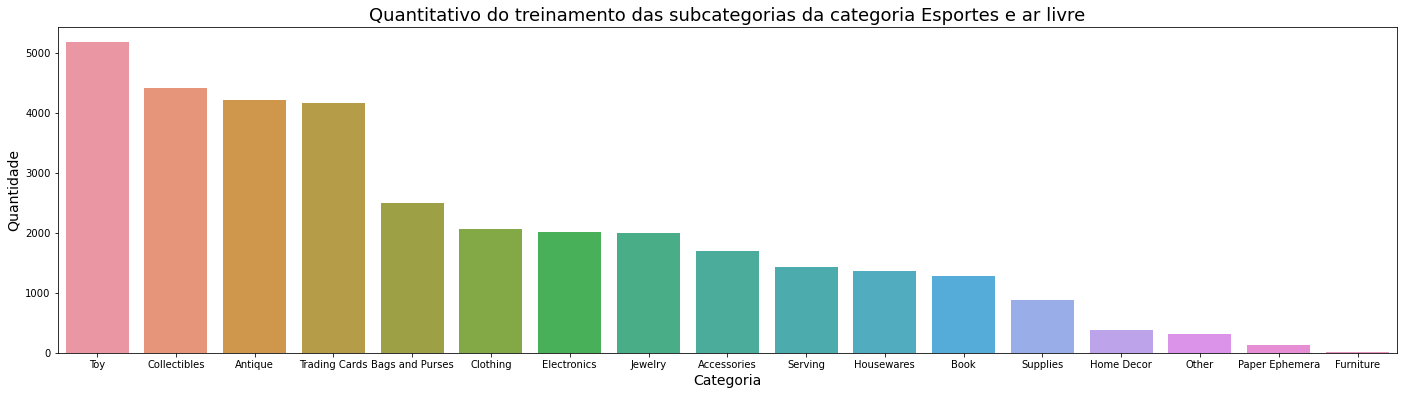

In [42]:
criar_barplot(vintage_collectibles_subcategories_count_train, 'Quantitativo do treinamento das subcategorias da categoria Esportes e ar livre', x = 'category_name', y='Count')

### Categoria Beleza | "Beauty"

In [43]:
column_beauty_train = second_category_dict_train['Beauty']['category_name'].reset_index(drop=True)
beauty_subcategories_count_train, __ , beauty_subcategories_percentage_train= selector.name_and_count_category_level(column_beauty_train, 1, percentage=True)
print(f'Valores totais do treinamento dentro da subcategoria {cf.BLUE}Beauty{cf.ENDC}')
beauty_subcategories_count_train

Valores totais do treinamento dentro da subcategoria Beauty


,category_name,Count
0,Makeup,47626
1,Skin Care,16182
2,Fragrance,13042
3,Tools & Accessories,8464
4,Hair Care,5764
5,Bath & Body,5451
6,Other,366


In [44]:
print(f'Valores percentuais do treinamento da subcategoria {cf.BLUE}Beauty{cf.ENDC}')
beauty_subcategories_percentage_train

Valores percentuais do treinamento da subcategoria Beauty


,category_name,Percentage
0,Makeup,0.491522
1,Skin Care,0.167006
2,Fragrance,0.134599
3,Tools & Accessories,0.087352
4,Hair Care,0.059487
5,Bath & Body,0.056257
6,Other,0.003777


<AxesSubplot:title={'center':'Quantitativo do treinamento das subcategorias da categoria Beleza'}, xlabel='Categoria', ylabel='Quantidade'>

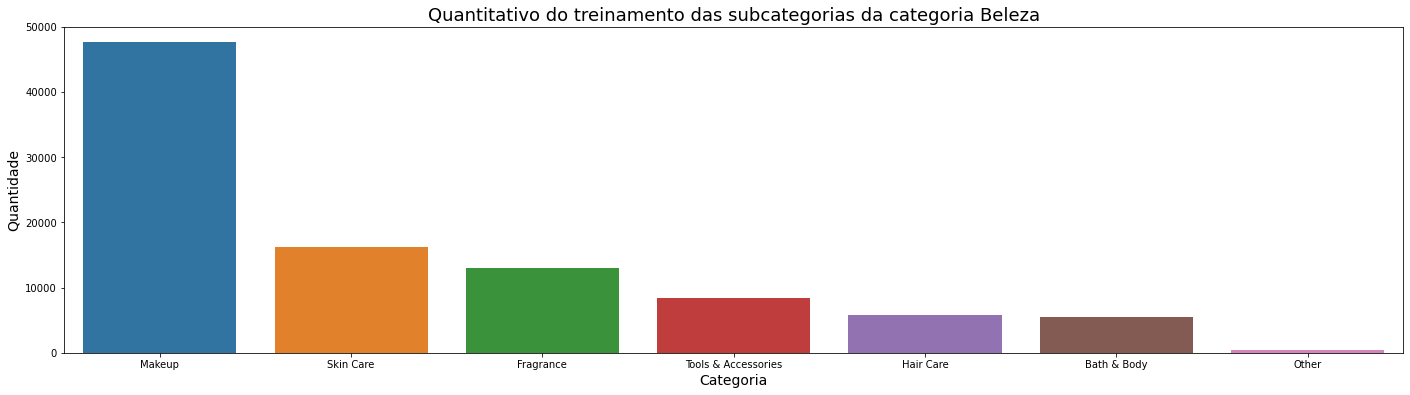

In [45]:
criar_barplot(beauty_subcategories_count_train, 'Quantitativo do treinamento das subcategorias da categoria Beleza', x = 'category_name', y='Count')

### Categoria Infantil | "Kids"

In [46]:
column_kids_train = second_category_dict_train['Kids']['category_name'].reset_index(drop=True)
kids_subcategories_count_train, __ , kids_subcategories_percentage_train= selector.name_and_count_category_level(column_kids_train, 1, percentage=True)
print(f'Valores totais do treinamento dentro da subcategoria {cf.BLUE}Kids{cf.ENDC}')
kids_subcategories_count_train

Valores totais do treinamento dentro da subcategoria Kids


,category_name,Count
0,Toys,34947
1,Girls 0-24 Mos,12126
2,Girls 2T-5T,11999
3,Girls (4+),10819
4,Boys 0-24 Mos,10304
5,Boys (4+),10206
6,Boys 2T-5T,9444
7,Feeding,3437
8,Diapering,2758
9,Gear,2296


In [47]:
print(f'Valores percentuais do treinamento da subcategoria {cf.BLUE}Kids{cf.ENDC}')
kids_subcategories_percentage_train

Valores percentuais do treinamento da subcategoria Kids


,category_name,Percentage
0,Toys,0.307367
1,Girls 0-24 Mos,0.106651
2,Girls 2T-5T,0.105534
3,Girls (4+),0.095156
4,Boys 0-24 Mos,0.090626
5,Boys (4+),0.089764
6,Boys 2T-5T,0.083062
7,Feeding,0.030229
8,Diapering,0.024257
9,Gear,0.020194


<AxesSubplot:title={'center':'Quantitativo do treinamento das subcategorias da categoria Infantil'}, xlabel='Categoria', ylabel='Quantidade'>

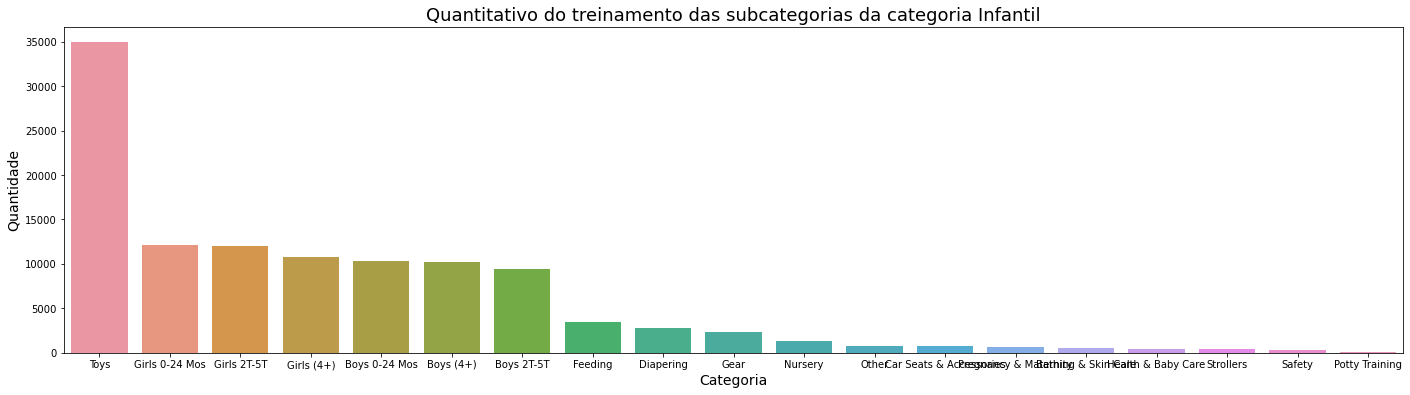

In [48]:
criar_barplot(kids_subcategories_count_train, 'Quantitativo do treinamento das subcategorias da categoria Infantil', x = 'category_name', y='Count')

# Teste

## Limpeza dos dados

In [49]:
test = clear_data_test(test)

In [50]:
#Função "processamento" já foi definida anteriormente
#Expressao regular para remover pontuacoes do texto da coluna 
description = test['item_description']
documentos_descript = []
for descript in description:

    #Expressao regular para remover pontuacoes do texto item_description
    descript = re.sub(r'[^\w\s]','', descript)
    tokens = processamento(word_tokenize(descript))

    documentos_descript.append(' '.join(tokens))

In [51]:
#Expressao regular para remover pontuacoes do texto da coluna name
name_2 = test['name']
documentos_name = []
for name_3 in name_2:


    sinopse = re.sub(r'[^\w\s]','', name_3)
    tokens = processamento(word_tokenize(name_3))

    documentos_name.append(' '.join(tokens))

In [52]:
#Criando a coluna documento_descript
test['description_clear'] = documentos_descript
test['name_clear'] = documentos_name

In [53]:
#Remoção dos itens duplicados
index_duplicated = test[test[['category_name', 'name_clear','description_clear','date']].duplicated()].index
test = test.drop(index_duplicated, axis=0).reset_index(drop=True)

test.head()

,name,item_condition_id,category_name,brand_name,shipping,item_description,date,stock,date2,day,month,year,description_clear,name_clear
0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,Other,1,Size 7,28-1-2018,2,2018-01-28,28,1,2018,size 7,breast cancer `` fight like girl '' ring
1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,Other,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined...",22-2-2018,7,2018-02-22,22,2,2018,25 pc new 75x12 kraft bubbl mailer line bubbl ...,25 pc new 7.5 '' x12 '' kraft bubbl mailer
2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...,29-1-2018,1,2018-01-29,29,1,2018,brand new coach bag bought rm coach outlet,coach bag
3,Floral Kimono,2,Women/Sweaters/Cardigan,Other,0,-floral kimono -never worn -lightweight and pe...,26-9-2018,4,2018-09-26,26,9,2018,floral kimono never worn lightweight perfect h...,floral kimono
4,Life after Death,3,Other/Books/Religion & Spirituality,Other,1,Rediscovering life after the loss of a loved o...,25-12-2018,5,2018-12-25,25,12,2018,rediscov life loss love one toni cook paperbac...,life death


## Seletor de categorias

In [54]:
general_selector_test = CategorySelector(test , test['category_name'], return_first_category=True, save_files = True, data_type='test')
first_category_test , second_category_dict_test = general_selector_test.get_categories()

### Primeira categoria

In [55]:
first_category_test

,category_name,Count
0,Women,310042
1,Beauty,97264
2,Kids,80225
3,Electronics,57677
4,Men,44064
5,Home,31966
6,Other,22812
7,Vintage & Collectibles,21410
8,Handmade,14333
9,Sports & Outdoors,11898


<AxesSubplot:title={'center':'Quantidade total de categorias principais dentro da base de teste'}, xlabel='Categoria', ylabel='Quantidade'>

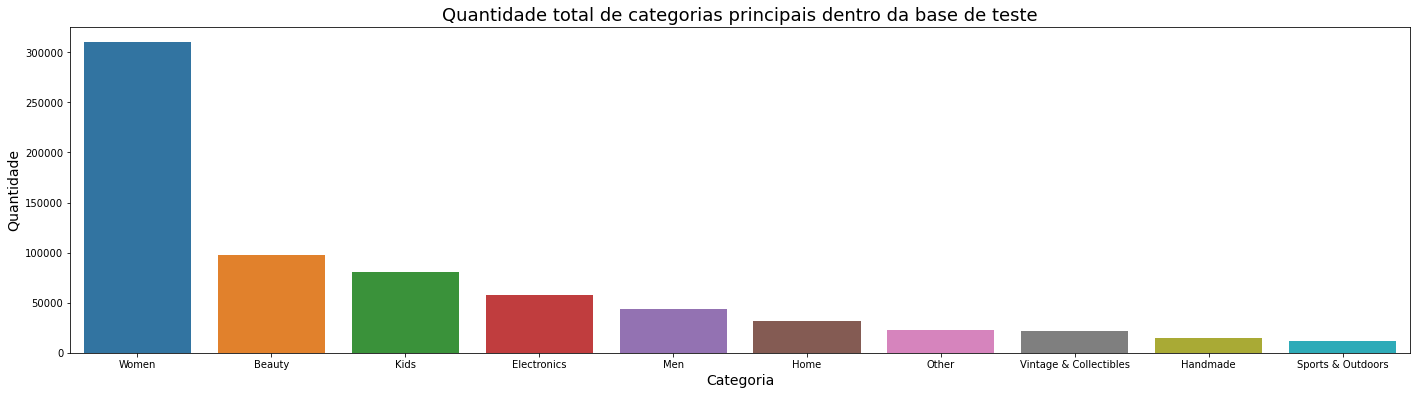

In [56]:
criar_barplot(first_category_test,'Quantidade total de categorias principais dentro da base de teste',x = 'category_name', y = 'Count')

### Categoria Homem | "Men"

In [57]:
# Já que será chamado uma função secundária da classe, é preciso apenas chamar a classe, não inicia-la
selector = CategorySelector

In [58]:
# O raciocínio da lógica através da construção dos código pode ser conferido na célula 21

column_men_test = second_category_dict_test['Men']['category_name'].reset_index(drop=True)
men_subcategories_count_test, __ , men_subcategories_percentage_test = selector.name_and_count_category_level(column_men_test, 1, percentage=True)
print(f'Valores totais do teste dentro da subcategoria {cf.BLUE}Men{cf.ENDC}')
men_subcategories_count_test

Valores totais do teste dentro da subcategoria Men


,category_name,Count
0,Shoes,10642
1,Tops,9769
2,Men's Accessories,8748
3,Athletic Apparel,5083
4,Sweats & Hoodies,3896
5,Jeans,1805
6,Coats & Jackets,1553
7,Shorts,749
8,Sweaters,684
9,Pants,419


In [59]:
print(f'Valores percentuais do teste da subcategoria {cf.BLUE}Men{cf.ENDC}')
men_subcategories_percentage_test

Valores percentuais do teste da subcategoria Men


,category_name,Percentage
0,Shoes,0.241512
1,Tops,0.221700
2,Men's Accessories,0.198529
3,Athletic Apparel,0.115355
4,Sweats & Hoodies,0.088417
5,Jeans,0.040963
6,Coats & Jackets,0.035244
7,Shorts,0.016998
8,Sweaters,0.015523
9,Pants,0.009509


<AxesSubplot:title={'center':'Quantitativo do teste das subcategorias da categoria Homem'}, xlabel='Categoria', ylabel='Quantidade'>

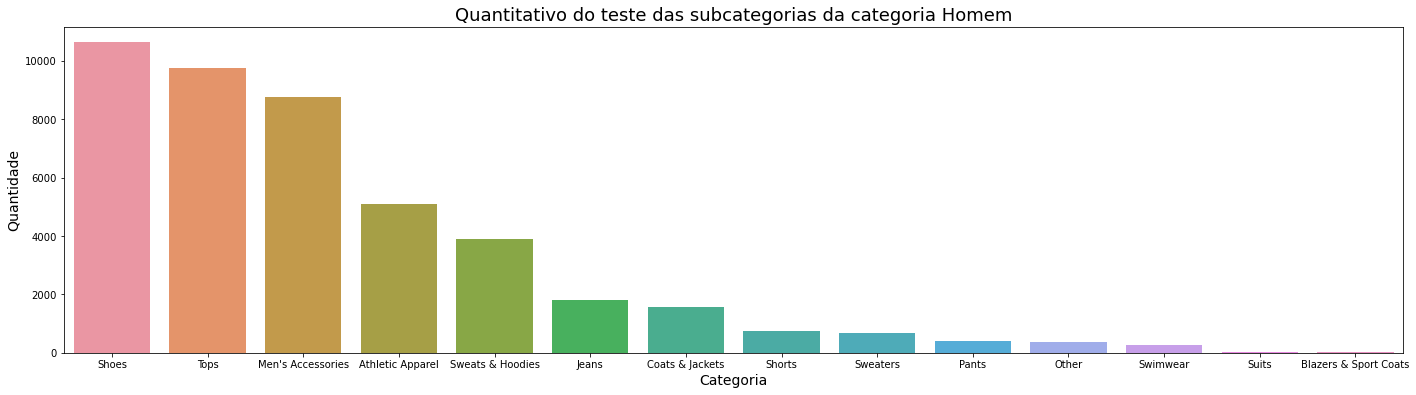

In [60]:
criar_barplot(men_subcategories_count_test, 'Quantitativo do teste das subcategorias da categoria Homem', x = 'category_name', y='Count')

### Categoria Mulher | "Women"

In [61]:
column_women_test = second_category_dict_test['Women']['category_name'].reset_index(drop=True)
women_subcategories_count_test, __ , women_subcategories_percentage_test = selector.name_and_count_category_level(column_women_test, 1, percentage=True)
print(f'Valores totais do teste de teste dentro da subcategoria {cf.BLUE}Women{cf.ENDC}')
women_subcategories_count_test

Valores totais do teste de teste dentro da subcategoria Women


,category_name,Count
0,Athletic Apparel,57569
1,Tops & Blouses,50308
2,Shoes,36113
3,Jewelry,26395
4,Dresses,21490
5,Women's Handbags,21393
6,Women's Accessories,19704
7,Underwear,15976
8,Sweaters,15850
9,Jeans,15154


In [62]:
print(f'Valores percentuais do teste da subcategoria {cf.BLUE}Women{cf.ENDC}')
women_subcategories_percentage_test

Valores percentuais do teste da subcategoria Women


,category_name,Percentage
0,Athletic Apparel,0.185681
1,Tops & Blouses,0.162262
2,Shoes,0.116478
3,Jewelry,0.085134
4,Dresses,0.069313
5,Women's Handbags,0.069000
6,Women's Accessories,0.063553
7,Underwear,0.051529
8,Sweaters,0.051122
9,Jeans,0.048877


<AxesSubplot:title={'center':'Quantitativo do teste de teste das subcategorias da categoria Homem'}, xlabel='Categoria', ylabel='Quantidade'>

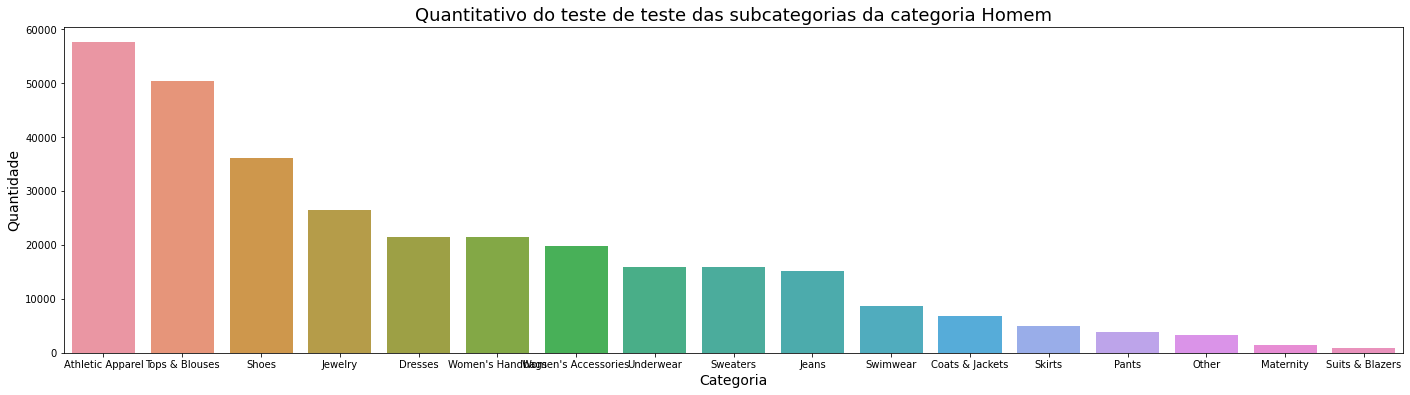

In [63]:
criar_barplot(women_subcategories_count_test, 'Quantitativo do teste de teste das subcategorias da categoria Homem', x = 'category_name', y='Count')

### Categoria Antigos e Colecionáveis | "Vintage & Collectibles"

In [64]:
column_vintage_collectibles_test = second_category_dict_test['Vintage & Collectibles']['category_name'].reset_index(drop=True)
vintage_collectibles_subcategories_count_test, __ , vintage_collectibles_subcategories_percentage_test= selector.name_and_count_category_level(column_vintage_collectibles_test, 1, percentage=True)
print(f'Valores totais do teste dentro da subcategoria {cf.BLUE}Vintage & Collectibles{cf.ENDC}')
vintage_collectibles_subcategories_count_test

Valores totais do teste dentro da subcategoria Vintage & Collectibles


,category_name,Count
0,Toy,3338
1,Trading Cards,3107
2,Antique,2806
3,Collectibles,2722
4,Bags and Purses,1413
5,Clothing,1209
6,Electronics,1193
7,Jewelry,1116
8,Accessories,1081
9,Serving,883


In [65]:
print(f'Valores percentuais do teste da subcategoria {cf.BLUE}Vintage & Collectibles{cf.ENDC}')
vintage_collectibles_subcategories_percentage_test

Valores percentuais do teste da subcategoria Vintage & Collectibles


,category_name,Percentage
0,Toy,0.155908
1,Trading Cards,0.145119
2,Antique,0.131060
3,Collectibles,0.127137
4,Bags and Purses,0.065997
5,Clothing,0.056469
6,Electronics,0.055722
7,Jewelry,0.052125
8,Accessories,0.050490
9,Serving,0.041242


<AxesSubplot:title={'center':'Quantitativo do teste de teste das subcategorias da categoria Homem'}, xlabel='Categoria', ylabel='Quantidade'>

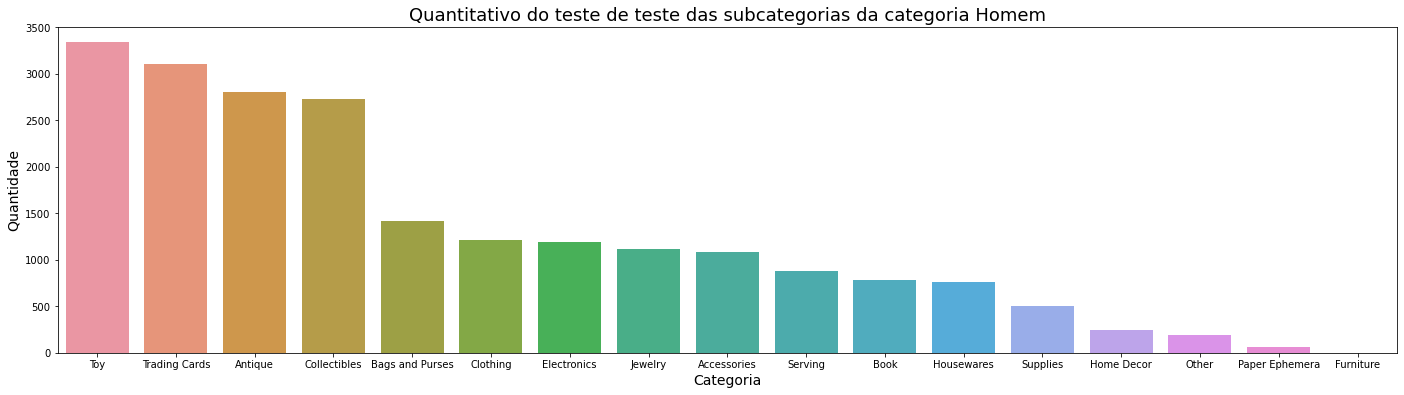

In [66]:
criar_barplot(vintage_collectibles_subcategories_count_test, 'Quantitativo do teste de teste das subcategorias da categoria Homem', x = 'category_name', y='Count')

### Categoria Feito a mão | "Handmade"

In [67]:
column_handmade_test = second_category_dict_test['Handmade']['category_name'].reset_index(drop=True)
handmade_subcategories_count_test, __ , handmade_subcategories_percentage_test= selector.name_and_count_category_level(column_handmade_test, 1, percentage=True)
print(f'Valores totais dentro do teste da subcategoria {cf.BLUE}Handmade{cf.ENDC}')
handmade_subcategories_count_test

Valores totais dentro do teste da subcategoria Handmade


,category_name,Count
0,Paper Goods,2972
1,Clothing,2708
2,Accessories,2624
3,Bags and Purses,1410
4,Jewelry,1111
5,Children,607
6,Music,423
7,Art,305
8,Weddings,287
9,Glass,267


In [68]:
print(f'Valores percentuais do teste da subcategoria {cf.BLUE}Handmade{cf.ENDC}')
handmade_subcategories_percentage_test

Valores percentuais do teste da subcategoria Handmade


,category_name,Percentage
0,Paper Goods,0.207354
1,Clothing,0.188935
2,Accessories,0.183074
3,Bags and Purses,0.098374
4,Jewelry,0.077513
5,Children,0.042350
6,Music,0.029512
7,Art,0.021280
8,Weddings,0.020024
9,Glass,0.018628


<AxesSubplot:title={'center':'Quantitativo do teste de teste das subcategorias da categoria Homem'}, xlabel='Categoria', ylabel='Quantidade'>

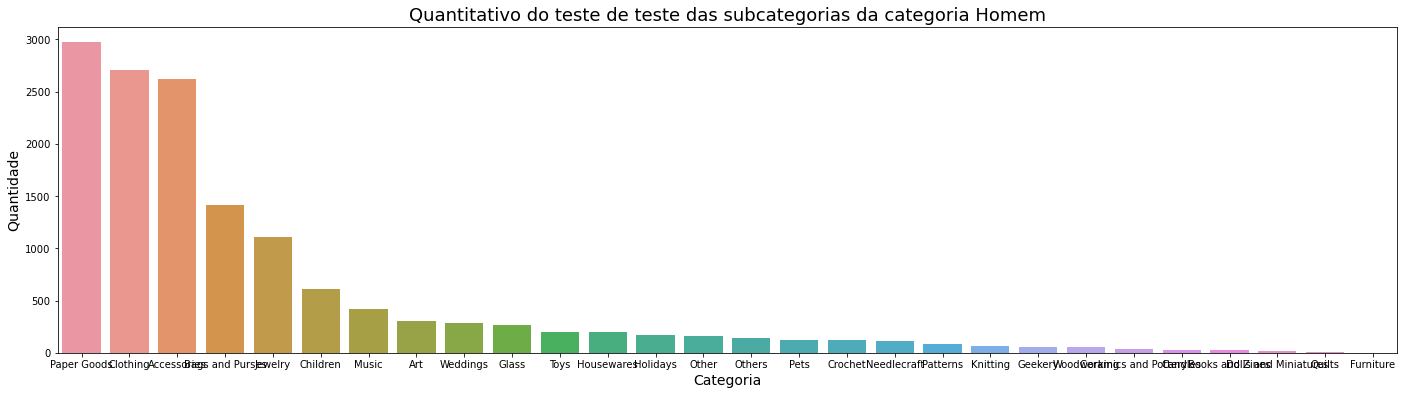

In [69]:
criar_barplot(handmade_subcategories_count_test, 'Quantitativo do teste de teste das subcategorias da categoria Homem', x = 'category_name', y='Count')

### Categoria Eletronicos | "Electronics"

In [70]:
column_eletronics_test = second_category_dict_test['Electronics']['category_name'].reset_index(drop=True)
eletronics_subcategories_count_test, __ , eletronics_subcategories_percentage_test= selector.name_and_count_category_level(column_eletronics_test, 1, percentage=True)
print(f'Valores totais do teste dentro da subcategoria {cf.BLUE}Electronics{cf.ENDC}')
eletronics_subcategories_count_test

Valores totais do teste dentro da subcategoria Electronics


,category_name,Count
0,Cell Phones & Accessories,24974
1,Video Games & Consoles,17049
2,Media,5513
3,"TV, Audio & Surveillance",4199
4,Computers & Tablets,3468
5,Cameras & Photography,1894
6,Other,333
7,"Car Audio, Video & GPS",247


In [71]:
print(f'Valores percentuais do teste da subcategoria {cf.BLUE}Electronics{cf.ENDC}')
eletronics_subcategories_count_test

Valores percentuais do teste da subcategoria Electronics


,category_name,Count
0,Cell Phones & Accessories,24974
1,Video Games & Consoles,17049
2,Media,5513
3,"TV, Audio & Surveillance",4199
4,Computers & Tablets,3468
5,Cameras & Photography,1894
6,Other,333
7,"Car Audio, Video & GPS",247


<AxesSubplot:title={'center':'Quantitativo do teste das subcategorias da categoria Eletronicos'}, xlabel='Categoria', ylabel='Quantidade'>

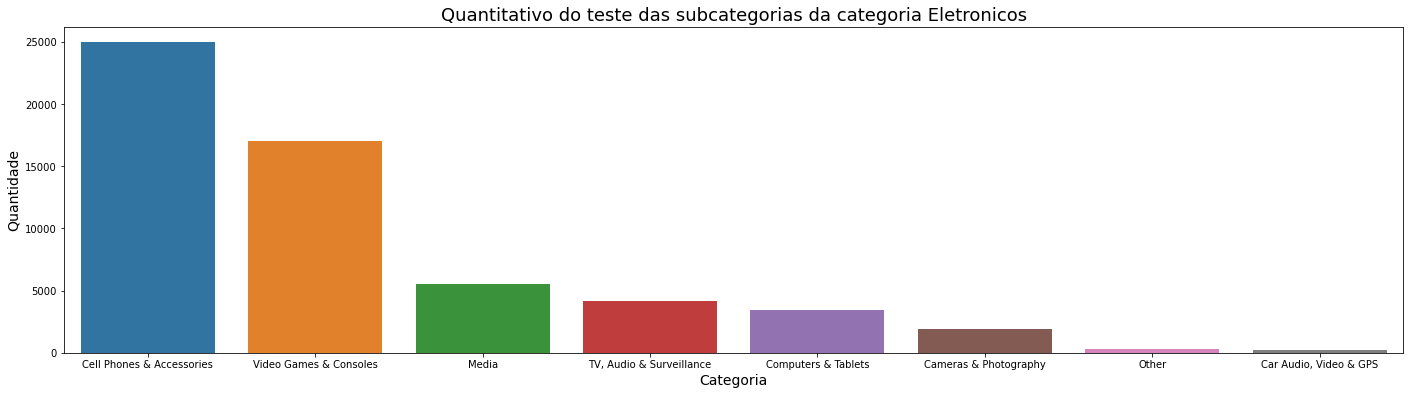

In [72]:
criar_barplot(eletronics_subcategories_count_test, 'Quantitativo do teste das subcategorias da categoria Eletronicos', x = 'category_name', y='Count')

### Categoria Casa | "Home"

In [73]:
column_home_test = second_category_dict_test['Home']['category_name'].reset_index(drop=True)
home_subcategories_count_test, __ , home_subcategories_percentage_test= selector.name_and_count_category_level(column_home_test, 1, percentage=True)
print(f'Valores totais do teste dentro da subcategoria {cf.BLUE}Vintage & Collectibles{cf.ENDC}')
home_subcategories_count_test

Valores totais do teste dentro da subcategoria Vintage & Collectibles


,category_name,Count
0,Home Décor,11822
1,Kitchen & Dining,10485
2,Seasonal Décor,2263
3,Bedding,1924
4,Storage & Organization,1330
5,Home Appliances,1262
6,Cleaning Supplies,1127
7,Artwork,578
8,Bath,521
9,Kids' Home Store,349


In [74]:
print(f'Valores percentuais do teste da subcategoria {cf.BLUE}Home{cf.ENDC}')
home_subcategories_percentage_test

Valores percentuais do teste da subcategoria Home


,category_name,Percentage
0,Home Décor,0.369830
1,Kitchen & Dining,0.328005
2,Seasonal Décor,0.070794
3,Bedding,0.060189
4,Storage & Organization,0.041607
5,Home Appliances,0.039479
6,Cleaning Supplies,0.035256
7,Artwork,0.018082
8,Bath,0.016299
9,Kids' Home Store,0.010918


<AxesSubplot:title={'center':'Quantitativo do teste das subcategorias da categoria Casa'}, xlabel='Categoria', ylabel='Quantidade'>

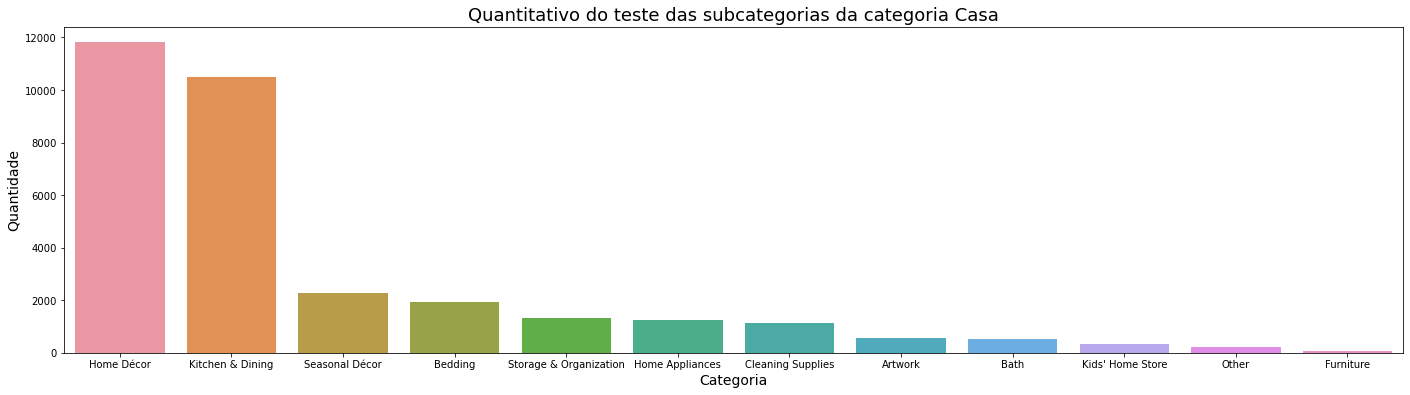

In [75]:
criar_barplot(home_subcategories_count_test, 'Quantitativo do teste das subcategorias da categoria Casa', x = 'category_name', y='Count')

### Categoria Esportes e ar livre | "Sports & Outdoors"

In [76]:
column_sports_outdoors_test = second_category_dict_test['Sports & Outdoors']['category_name'].reset_index(drop=True)
sports_outdoors_subcategories_count_test, __ , sports_outdoors_subcategories_percentage_test= selector.name_and_count_category_level(column_sports_outdoors_test, 1, percentage=True)
print(f'Valores totais do teste dentro da subcategoria {cf.BLUE}Sports & Outdoors{cf.ENDC}')
sports_outdoors_subcategories_count_test

Valores totais do teste dentro da subcategoria Sports & Outdoors


,category_name,Count
0,Exercise,3740
1,Fan Shop,2971
2,Outdoors,2014
3,Apparel,1415
4,Team Sports,977
5,Golf,356
6,Footwear,253
7,Other,172


In [77]:
print(f'Valores percentuais do teste da subcategoria {cf.BLUE}Sports & Outdoors{cf.ENDC}')
sports_outdoors_subcategories_percentage_test

Valores percentuais do teste da subcategoria Sports & Outdoors


,category_name,Percentage
0,Exercise,0.314339
1,Fan Shop,0.249706
2,Outdoors,0.169272
3,Apparel,0.118928
4,Team Sports,0.082115
5,Golf,0.029921
6,Footwear,0.021264
7,Other,0.014456


<AxesSubplot:title={'center':'Quantitativo do teste das subcategorias da categoria Esportes e ar livre'}, xlabel='Categoria', ylabel='Quantidade'>

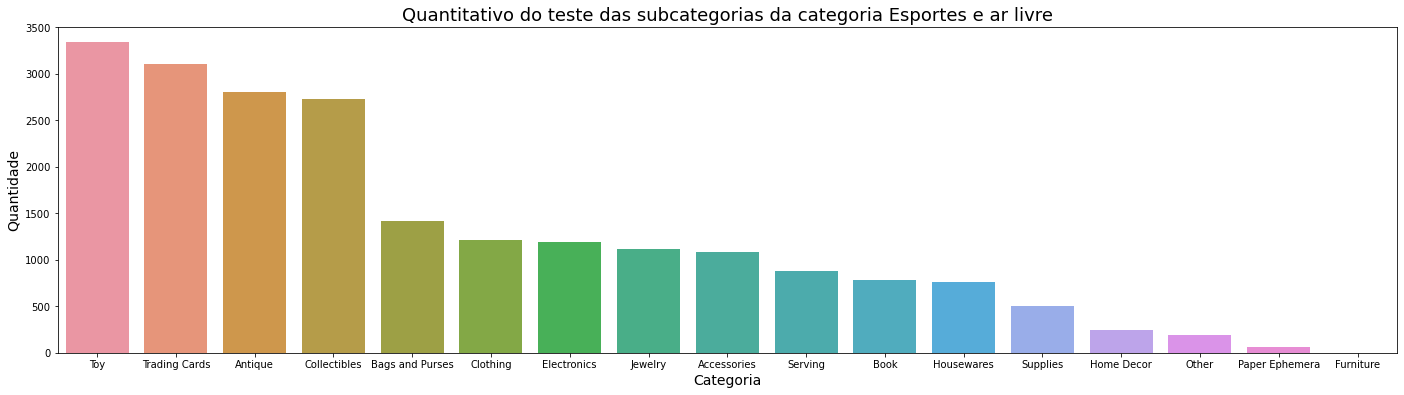

In [78]:
criar_barplot(vintage_collectibles_subcategories_count_test, 'Quantitativo do teste das subcategorias da categoria Esportes e ar livre', x = 'category_name', y='Count')

### Categoria Beleza | "Beauty"

In [79]:
column_beauty_test = second_category_dict_test['Beauty']['category_name'].reset_index(drop=True)
beauty_subcategories_count_test, __ , beauty_subcategories_percentage_test= selector.name_and_count_category_level(column_beauty_test, 1, percentage=True)
print(f'Valores totais do teste dentro da subcategoria {cf.BLUE}Beauty{cf.ENDC}')
beauty_subcategories_count_test

Valores totais do teste dentro da subcategoria Beauty


,category_name,Count
0,Makeup,58424
1,Skin Care,13845
2,Fragrance,11539
3,Tools & Accessories,6133
4,Hair Care,3568
5,Bath & Body,3519
6,Other,236


In [80]:
print(f'Valores percentuais do teste da subcategoria {cf.BLUE}Beauty{cf.ENDC}')
beauty_subcategories_percentage_test

Valores percentuais do teste da subcategoria Beauty


,category_name,Percentage
0,Makeup,0.600674
1,Skin Care,0.142345
2,Fragrance,0.118636
3,Tools & Accessories,0.063055
4,Hair Care,0.036684
5,Bath & Body,0.036180
6,Other,0.002426


<AxesSubplot:title={'center':'Quantitativo do teste das subcategorias da categoria Beleza'}, xlabel='Categoria', ylabel='Quantidade'>

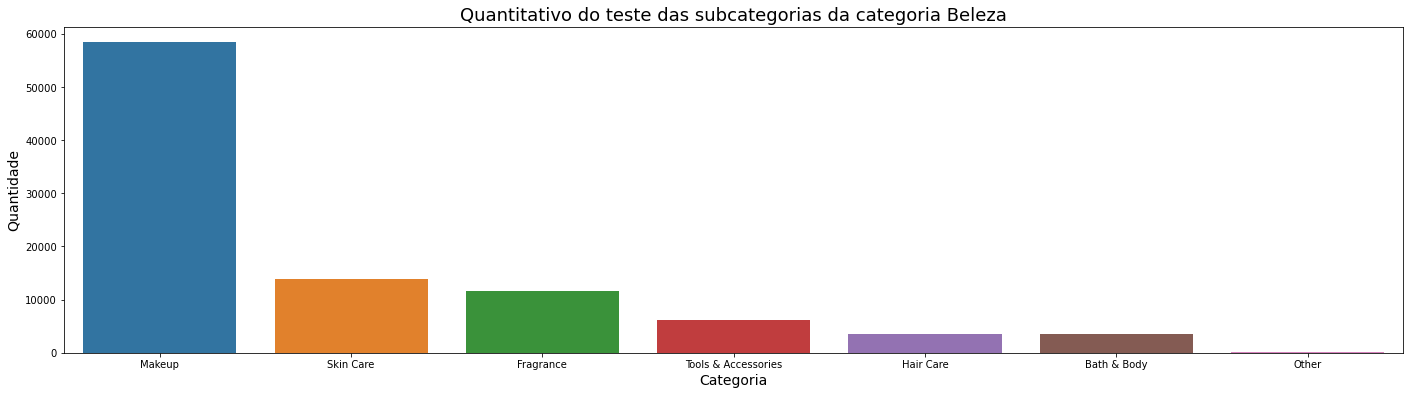

In [81]:
criar_barplot(beauty_subcategories_count_test, 'Quantitativo do teste das subcategorias da categoria Beleza', x = 'category_name', y='Count')

### Categoria Infantil | "Kids"

In [82]:
column_kids_test = second_category_dict_test['Kids']['category_name'].reset_index(drop=True)
kids_subcategories_count_test, __ , kids_subcategories_percentage_test= selector.name_and_count_category_level(column_kids_test, 1, percentage=True)
print(f'Valores totais do teste dentro da subcategoria {cf.BLUE}Kids{cf.ENDC}')
kids_subcategories_count_test

Valores totais do teste dentro da subcategoria Kids


,category_name,Count
0,Toys,26866
1,Girls 2T-5T,8460
2,Girls 0-24 Mos,8303
3,Girls (4+),7328
4,Boys 0-24 Mos,7081
5,Boys (4+),6897
6,Boys 2T-5T,6845
7,Feeding,2069
8,Diapering,1691
9,Gear,1410


In [83]:
print(f'Valores percentuais do teste da subcategoria {cf.BLUE}Kids{cf.ENDC}')
kids_subcategories_percentage_test

Valores percentuais do teste da subcategoria Kids


,category_name,Percentage
0,Toys,0.334883
1,Girls 2T-5T,0.105453
2,Girls 0-24 Mos,0.103496
3,Girls (4+),0.091343
4,Boys 0-24 Mos,0.088264
5,Boys (4+),0.085971
6,Boys 2T-5T,0.085323
7,Feeding,0.025790
8,Diapering,0.021078
9,Gear,0.017576


<AxesSubplot:title={'center':'Quantitativo do teste das subcategorias da categoria Infantil'}, xlabel='Categoria', ylabel='Quantidade'>

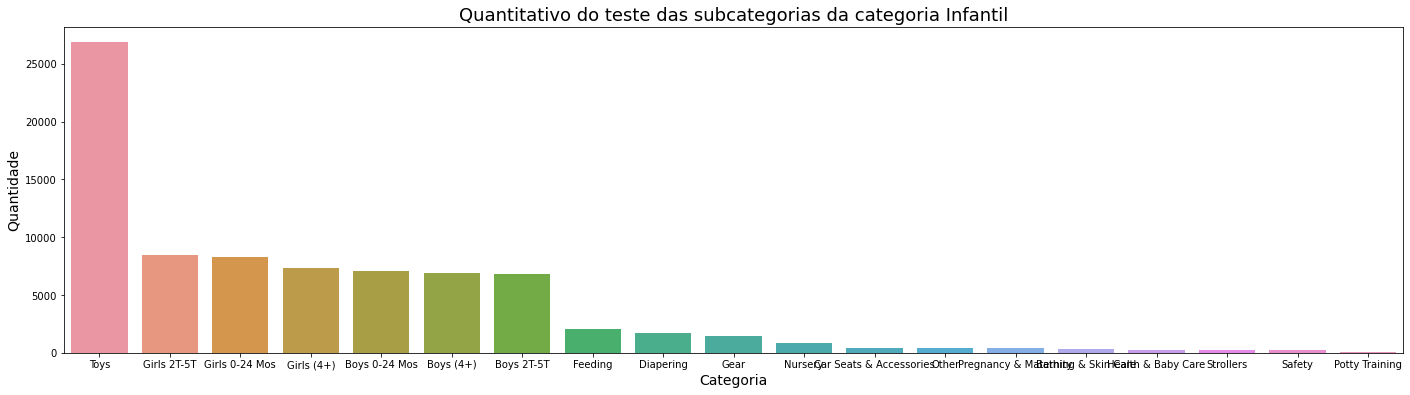

In [84]:
criar_barplot(kids_subcategories_count_test, 'Quantitativo do teste das subcategorias da categoria Infantil', x = 'category_name', y='Count')

# Considerações finais

## Sprint 1

### Principais desafios

- Construção das hipóteses
- Definição das atividades
- Otimização de processos
- Identificar padrões de preço levando em relação os produtos anunciados
- Trabalhar com ferramentas novas como mirro e trello
- Analisar os dados, identificando valores nulos e duplicados

### Observações

- Neste sprint foi utilizado o arquivo completo para os estudos preeliminares, todavia, para estudos posteriores, serão utilizados arquivos que estão divididos através das categorias principais.